In [53]:
import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import PollingSystem as PS
import MarkovianRP as MRP
import StaticRP as SRP
import dtr
import motion
import sim_template as sim
from importlib import reload 
import TSPN

In [3]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [4]:
#If we're feeling it
if False:
    %store -r dt_sys AORP TSPNP tjcps pjcps qBase region pcs pfs pjcps prob_pred_con ccs cfs true_joint_con_fields tjcps

In [5]:
#Setup the communication environment:

#For now, use same channel params, basd on the San Francisco measurements
nPL = 5.2 # per SF data should be in [2, 10]
kPL = -20 # per SF data, [-20, 90]

decorrSH = 2.09    
alpha = 16 # per SF data [4,100]%too high - worse prediction
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5



#6 remote stations
l = 18
l_inner=5
c = np.array([25, 25])

qBase = np.array([c+l_inner*np.array([-(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([-(np.sqrt(3)/2), -1/2]), 
                  c+l_inner*np.array([(np.sqrt(3)/2), -1/2]), c+(l_inner+l)*np.array([(np.sqrt(3)/2), -1/2]),
                  [25, 25+l_inner], [25, 25+l_inner+l]])


sub_regions = [[28,4,25,0],
               [46,22, 25, 0],
               [33, 17, 47, 17]]



cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]

x_max = 50
x_min = 0
y_max = 50
y_min = 0
region = [x_max, x_min, y_max, y_min]

#res = 2/decorrMP
res = 10
n=3
p_th = 0.5

bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
els = [0.1/beta, 0.01/beta, 0.01/beta]

In [6]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


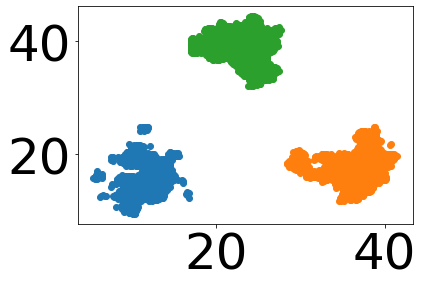

In [7]:
for points in tjcps:
    plt.scatter(points[:,0], points[:,1])

In [8]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)

print(prob_pred_con)

Drawing 600 samples from Channel 1
Completed PredictedChannel 1
Drawing 600 samples from Channel 2
Completed PredictedChannel 2
Drawing 600 samples from Channel 3
Completed PredictedChannel 3
Drawing 600 samples from Channel 4
Completed PredictedChannel 4
Drawing 480 samples from Channel 5
Completed PredictedChannel 5
Drawing 480 samples from Channel 6
Completed PredictedChannel 6
[0.8449399656946827, 0.7882592466915507, 0.8495029139526912]


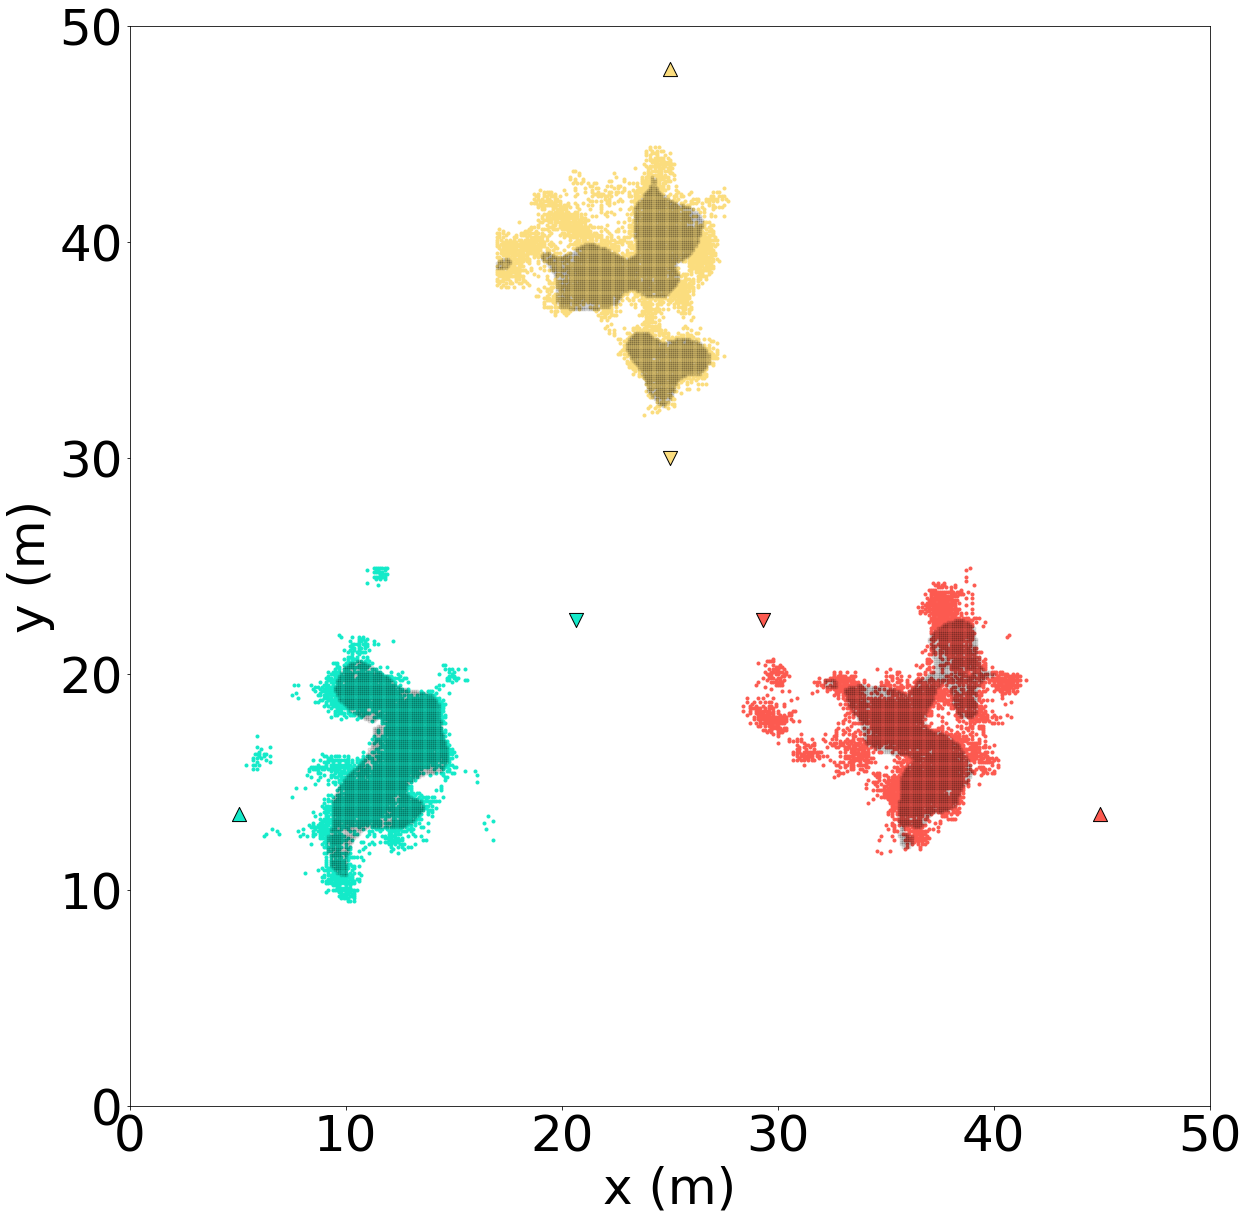

In [9]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [17]:
reload(MRP)
reload(PS)
reload(dtr)
reload(sim)




dt_sys = dtr.DTR(pcs, region, els, beta, th = GAMMA_TH, p_th=p_th)
ps = dt_sys.ps

Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
13 total subregions
Extracted edges...
No Improvement, orphaned edges exist
PolyConstructor: ([32.7 19.4])  ([33.1 19.3]) 
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
21 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
19 total subregions


In [259]:
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

TSPNP={'X':x, 'SEQ':tspn_argmin[1]}

Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 49.96
Elapsed Time: 0.21


In [36]:
reload(CPLX)
reload(dtr)
reload(TSPN)
reload(sim)
reload(PS)
#reload(MRP)
v = 1


plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})

print("Finding AORP")
AORP = sim.calc_AORP(dt_sys, v)
print("Found AORP")
pi = AORP['pi']
S = dtr.XtoS(AORP['X'])
S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]

#S_i = S @ pi
W_rnd = ps._calc_avg_wait_random(S, pi)
W_cy = ps._calc_avg_wait_cyclic(S_cyv)

#print(S)
P_tilde, pi_tilde = sim.pi_to_P(pi)
print(P_tilde)
S_i = np.diag(P_tilde@S)
print(els)
print(pi)
print(pi_tilde)
print(S_i)
print(W_rnd)
print(W_cy)

Finding AORP
Found AORP
[[0.         0.465676   0.534324  ]
 [0.99285259 0.         0.00714741]
 [0.99376514 0.00623486 0.        ]]
[1.6, 0.16, 0.16]
[0.98670627 0.00619057 0.00710316]
[0.49832943 0.23373062 0.26793994]
[18.13202291 22.38973358 14.4899749 ]
26.572913180962594
30.902237944042607


In [1]:
reload(sim)
hrs = 2
mins = 0
seconds = 0
print('Velocity = %f'%(v))
motion_power = motion.LinearMotionPower(7.2, 0.29, v)
sim.run_sims(dt_sys.ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)
print('done')

NameError: name 'reload' is not defined

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

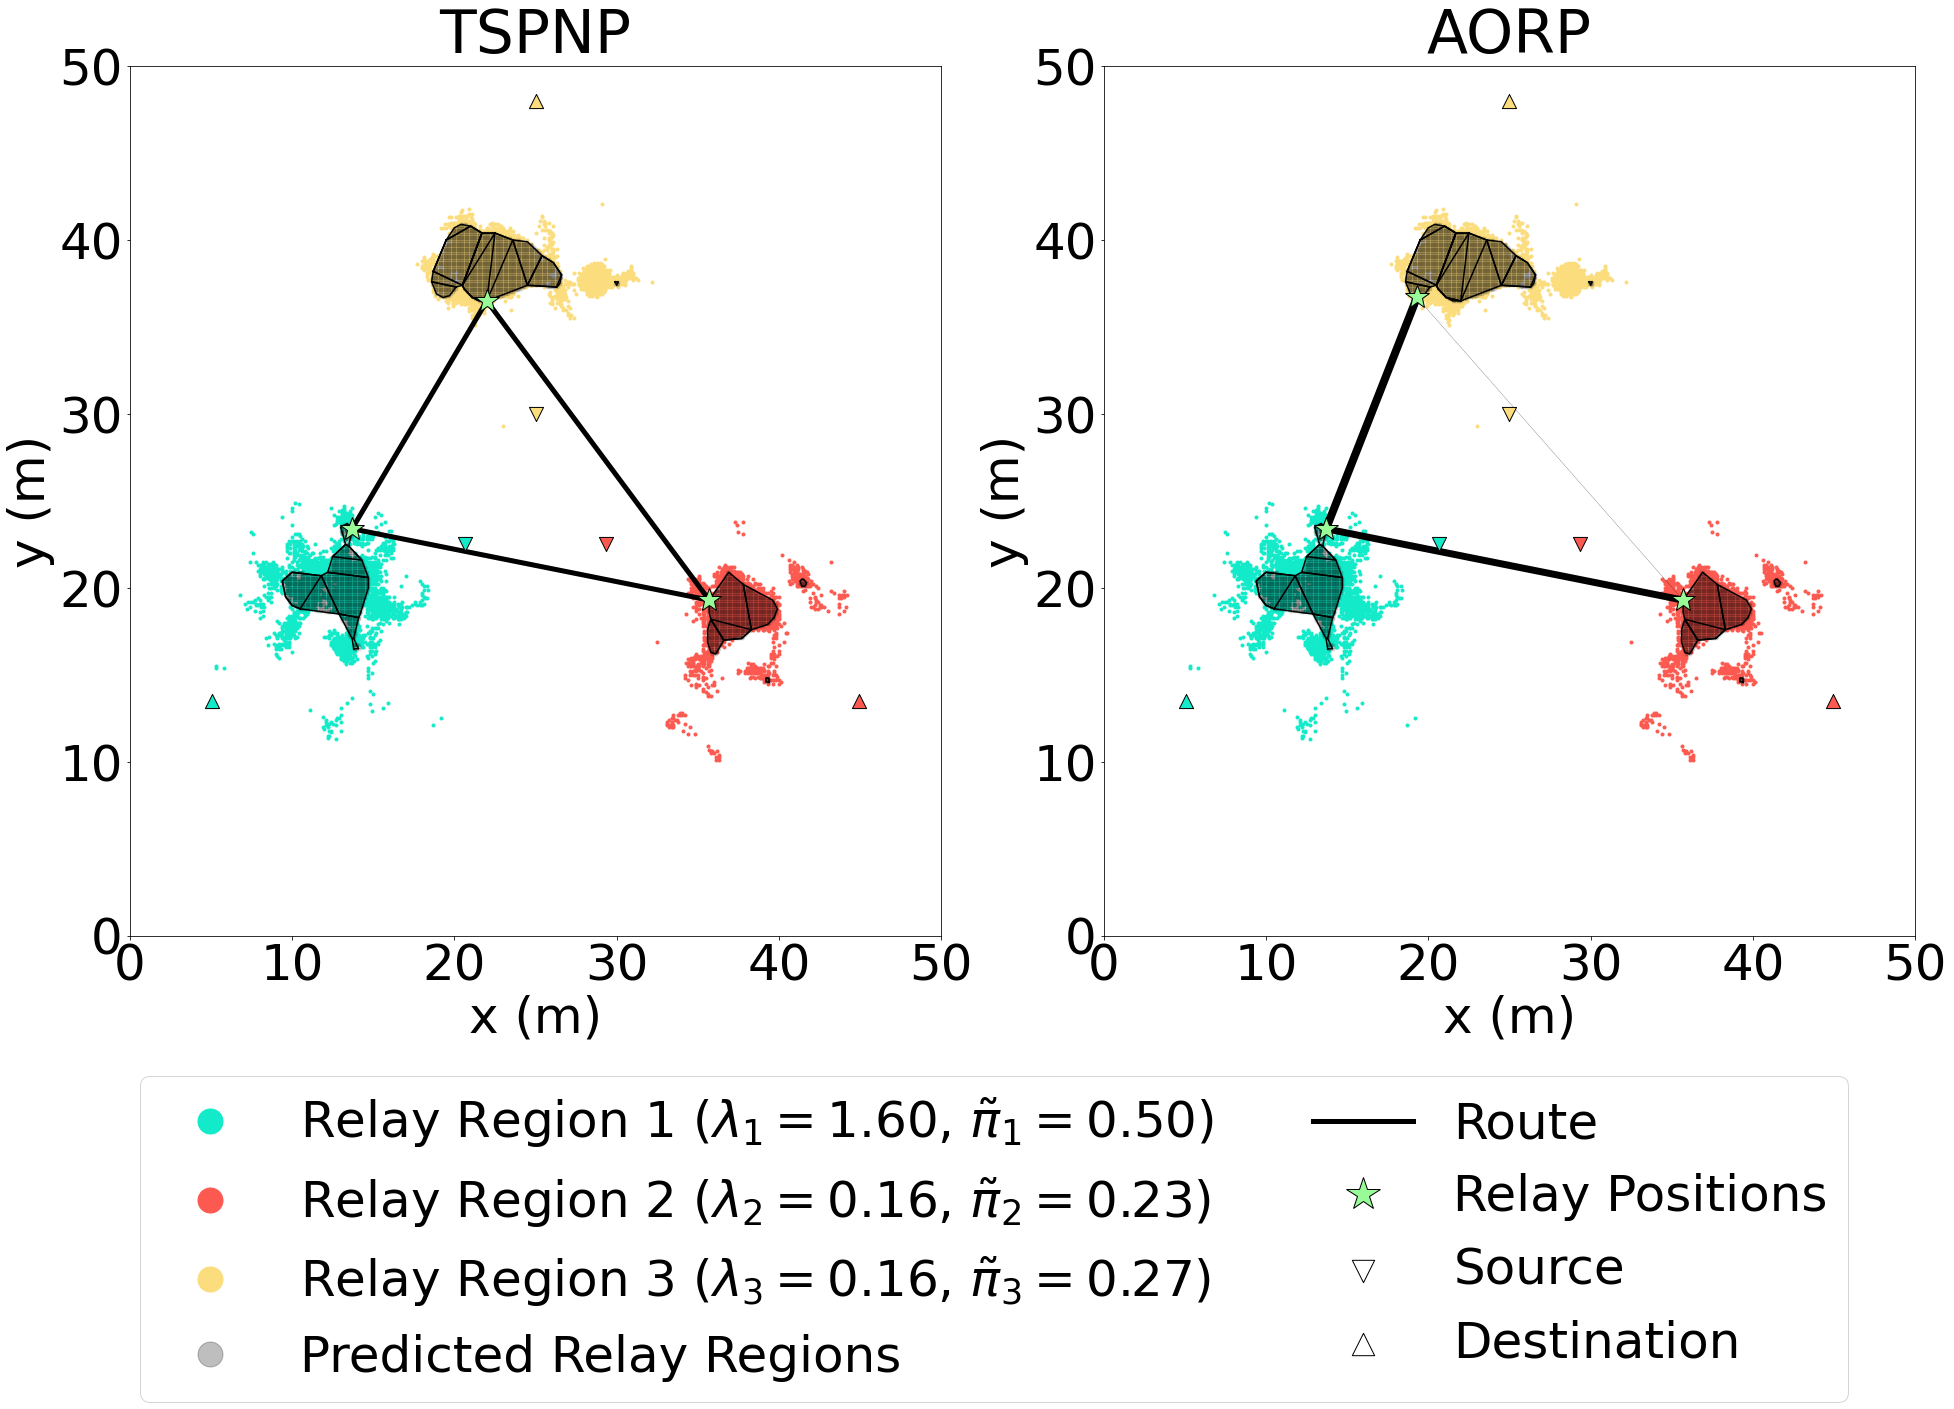

In [40]:
sim.plot_AORP_W_TSPN(dt_sys, AORP, TSPNP, tjcps, pjcps, qBase, region, els, pi)
plt.savefig("eqi_tri_TSPNP_v_AORP.png", format='png', bbox_inches='tight')
plt.savefig("eqi_tri_TSPNP_v_AORP.eps", format='eps', bbox_inches='tight')

In [261]:
#now look for trends
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})
v = 1
S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]
    
    
W_aorp = []
W_tab = []
W_tspnp = []
s_tilde = []
dispersion = []


scales = np.array([0.01, 0.25, 0.5, 0.75, 1, 2.5, 5., 7.5, 10, 15])
d = len(scales)
vals = np.tile(np.array([0.01/beta, 0.01/beta, 0.01/beta]), (d,1))
vals[:,0]*=scales

sys_traffic = 0.3
L_S = sys_traffic/beta

for val in vals:
    #normalize
    val = (val/np.sum(val))*L_S
    print(val)
    ps.Ls = val
    print("Finding AORP")
    AORP = sim.calc_AORP(dt_sys, v)
    print("Found AORP")
    pi = AORP['pi']
    S = dtr.XtoS(AORP['X'])
    
    #also look at the tabular version
    rtable = SRP.SRPFromPis(pi, eps=0.01)
    seconds = 2*60*60
    xt, wt, queues, total_travel_time, _, _, _ = ps.simulate(rtable, S, seconds)
    W_tab.append(wt[-1][1])
    #S_i = S @ pi
    W_rnd = ps._calc_avg_wait_random(S, pi)
    W_aorp.append(W_rnd)
    W_cy = ps._calc_avg_wait_cyclic(S_cyv)
    W_tspnp.append(W_cy)

    P_tilde, pi_tilde = sim.pi_to_P(pi)
    S_obs = pi_tilde.T @ (S*P_tilde) @np.ones((3,1))
    s_tilde.append(S_obs)
    
    X = AORP['X']
    X_avg = np.average(X,0, weights=val)
    diffs = X - X_avg
    dists = np.linalg.norm(diffs, axis=1)
    #normalize
    dists /= np.max(dists)
    dispersion.append(np.average(dists, weights=val))
    


[0.0238806 2.3880597 2.3880597]
Finding AORP
Found AORP
[0.53333333 2.13333333 2.13333333]
Finding AORP
Found AORP
[0.96 1.92 1.92]
Finding AORP
Found AORP
[1.30909091 1.74545455 1.74545455]
Finding AORP
Found AORP
[1.6 1.6 1.6]
Finding AORP
Found AORP
[2.66666667 1.06666667 1.06666667]
Finding AORP
Found AORP
[3.42857143 0.68571429 0.68571429]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[3.78947368 0.50526316 0.50526316]
Finding AORP
Found AORP
[4.  0.4 0.4]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[4.23529412 0.28235294 0.28235294]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP


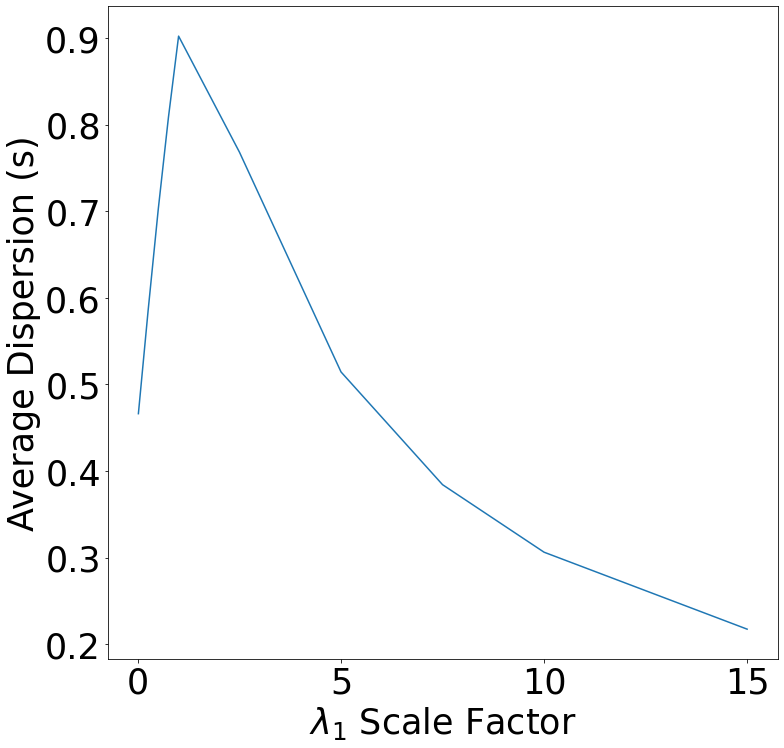

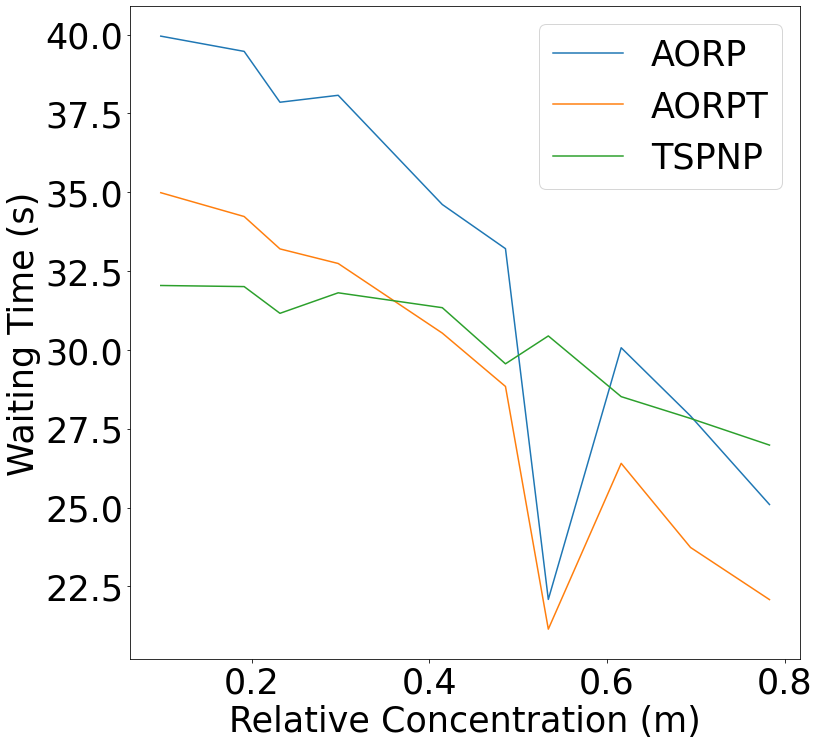

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


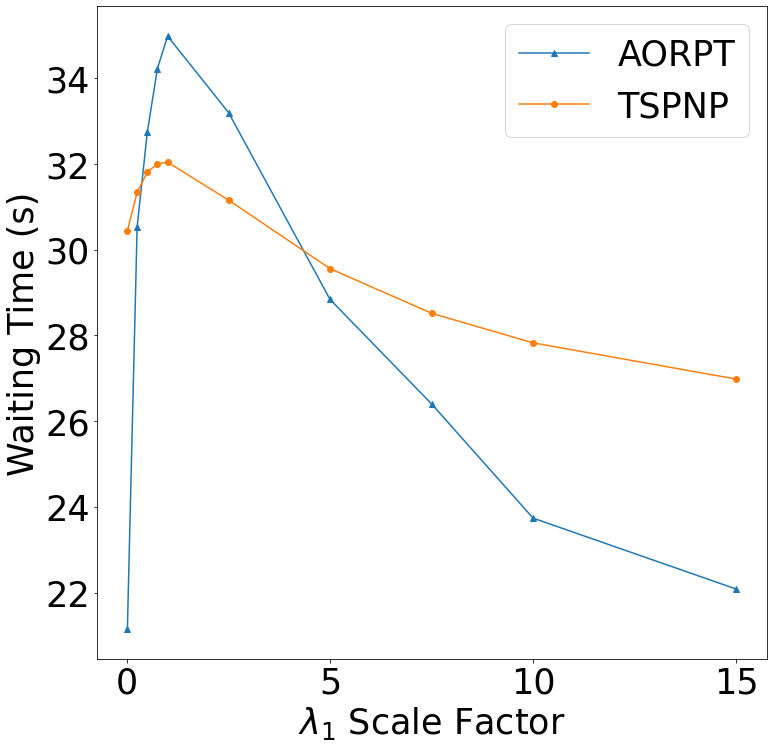

In [262]:
fig = plt.figure(figsize=(12,12))
plt.plot(scales, dispersion)
plt.xlabel("$\\lambda_1$ Scale Factor")
plt.ylabel("Average Dispersion (s)")
plt.show()

dispersion = np.array(dispersion)
conc = 1-dispersion
order = np.argsort(conc).tolist()

fig = plt.figure(figsize=(12,12))
W_aorp = np.array(W_aorp)
plt.plot(conc[order], W_aorp[order], label="AORP")
W_tab = np.array(W_tab)
plt.plot(conc[order], W_tab[order],  label="AORPT")
W_tspnp = np.array(W_tspnp)
plt.plot(conc[order], W_tspnp[order], label="TSPNP")
plt.xlabel("Relative Concentration (m)")
plt.ylabel("Waiting Time (s)")
plt.legend()
plt.show()

fig = plt.figure(figsize=(12,12))
#plt.plot(scales, W_aorp, '-s', label="AORP")
plt.plot(scales, W_tab, '-^', label="AORPT")
plt.plot(scales, W_tspnp, '-o', label="TSPNP")
plt.xlabel("$\\lambda_1$ Scale Factor")
plt.ylabel("Waiting Time (s)")
plt.legend()
plt.savefig("eq_tri_w_v_scale.png", format='png', bbox_inches='tight')
plt.savefig("eq_tri_w_v_scale.eps", format='eps', bbox_inches='tight')
plt.show()

In [122]:
#now look for trends
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})
v = 1
S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]
    
traffics = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
ntr = len(traffics)
scales = np.array([1, 5, 10, 15])
ns = len(scales)
vals = np.tile(np.array([0.01/beta, 0.01/beta, 0.01/beta]), (ns,1))
vals[:,0]*=scales


diffs = np.zeros((ntr, ns))

for i in range(ntr):
    sys_traffic = traffics[i]
    L_S = sys_traffic/beta

    for j in range(ns):
        #normalize
        val = vals[j]
        val = (val/np.sum(val))*L_S
        print(val)
        ps.Ls = val
        print("Finding AORP")
        AORP = sim.calc_AORP(dt_sys, v)
        print("Found AORP")
        pi = AORP['pi']
        S = dtr.XtoS(AORP['X'])

        #also look at the tabular version
        rtable = SRP.SRPFromPis(pi, eps=0.01)
        seconds = 2*60*60
        xt, wt, queues, total_travel_time, _, _, _ = ps.simulate(rtable, S, seconds)
        #S_i = S @ pi
        W_rnd = ps._calc_avg_wait_random(S, pi)
        W_cy = ps._calc_avg_wait_cyclic(S_cyv)
        
        diffs[i,j] = W_rnd - wt[-1][1]



[0.53333333 0.53333333 0.53333333]
Finding AORP
Found AORP
[1.14285714 0.22857143 0.22857143]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[1.33333333 0.13333333 0.13333333]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[1.41176471 0.09411765 0.09411765]
Finding AORP
Found AORP
[1.6 1.6 1.6]
Finding AORP
Found AORP
[3.42857143 0.68571429 0.68571429]
Finding AORP
Found AORP
[4.  0.4 0.4]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[4.23529412 0.28235294 0.28235294]
Finding AORP
Found AORP
[2.66666667 2.66666667 2.66666667]
Finding AORP
Found AORP
[5.71428571 1.14285714 1.14285714]
Finding AORP
Found AORP
[6.66666667 0.66666667 0.66666667]
Finding AORP
Found AORP
[7.05882353 0.47058824 0.47058824]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[3.73333333 3.73333333 3.73333333]
Finding AORP
Found AORP
[8.  1.6 1.6]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[9.33333333 0.93333333 0.93333333]
Finding AORP
Found AORP
[9.88235294 0.65882353 0.65882353]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[4.8 4.8 4.8]
Finding AORP
Found AORP
[10.28571429  2.05714286  2.05714286]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
[12.   1.2  1.2]
Finding AORP
Found AORP
[12.70588235  0.84705882  0.84705882]
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP


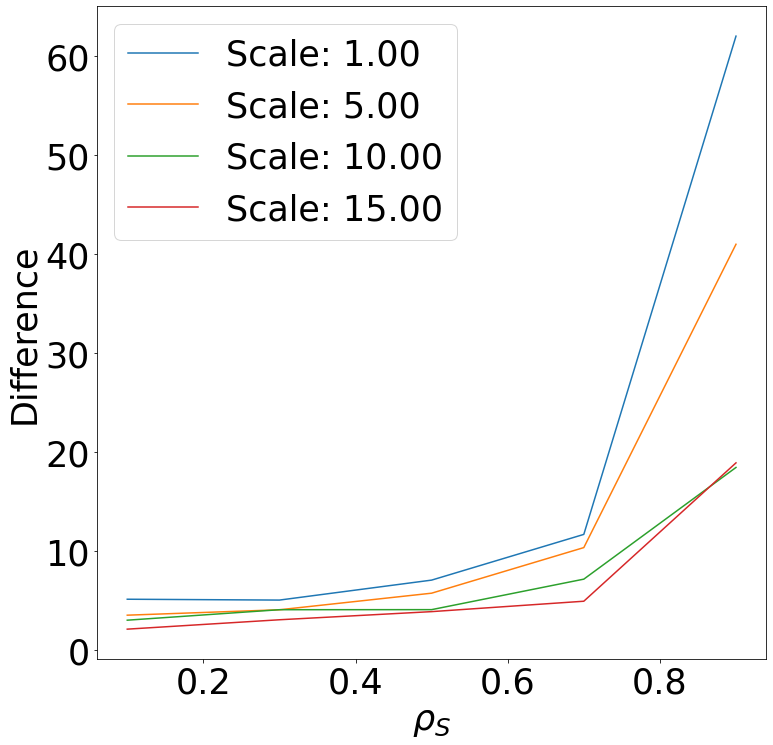

In [127]:
fig = plt.figure(figsize=(12,12))
for k in range(ns):
    plt.plot(traffics, diffs[:,k], label="Scale: %.2f"%(scales[k]))
plt.xlabel("$\\rho_S$")
plt.ylabel("Difference")
plt.legend()

In [214]:
#Now look at effect of switching times on 
reload(sim)
ps.Ls = np.array([0.1/beta, 0.01/beta, 0.01/beta])
print("Finding AORP")
AORP = sim.calc_AORP(dt_sys, v)
print("Found AORP")
pi = AORP['pi']
S = dtr.XtoS(AORP['X'])

#also look at the tabular version
rtable = SRP.SRPFromPis(pi, eps=0.01)
seconds = 2*60*60
xt, wt, queues, total_travel_time, _, _, _ = ps.simulate(rtable, S, seconds)

Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP


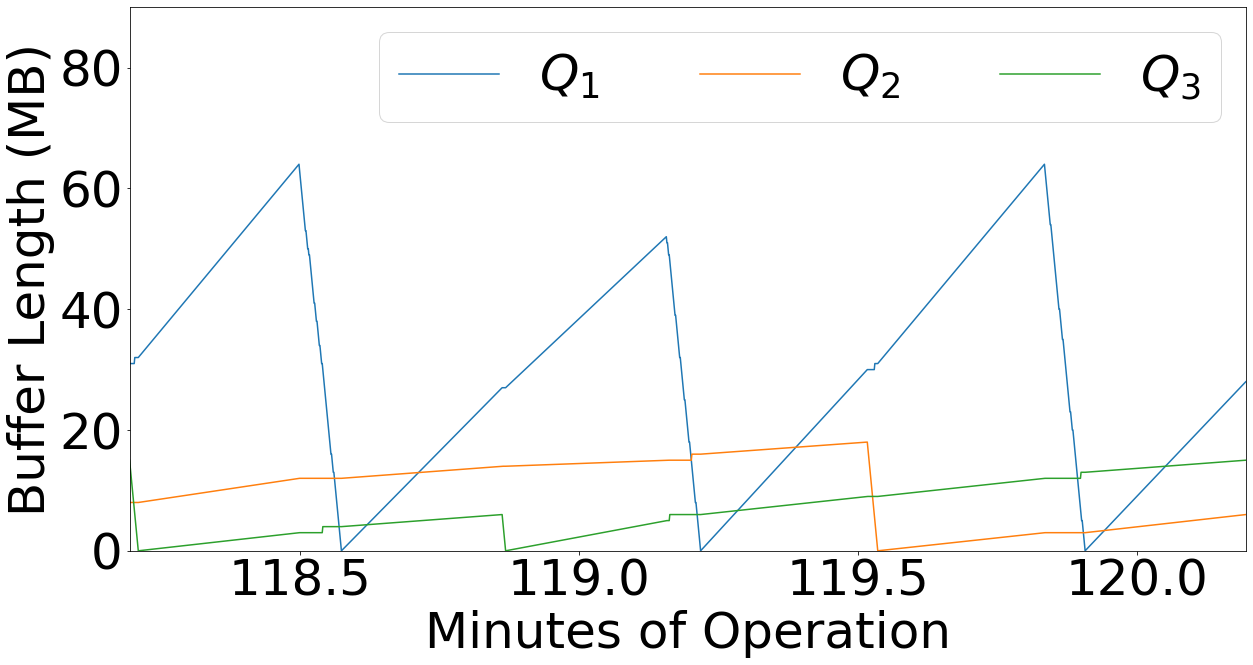

In [206]:
reload(sim)
sim.plotLastMins(xt, 2)
plt.ylim(0,90)
plt.show()

In [198]:
xtv2, wt, queues, total_travel_time, _, _, _ = ps.simulate(rtable, S/2, seconds)

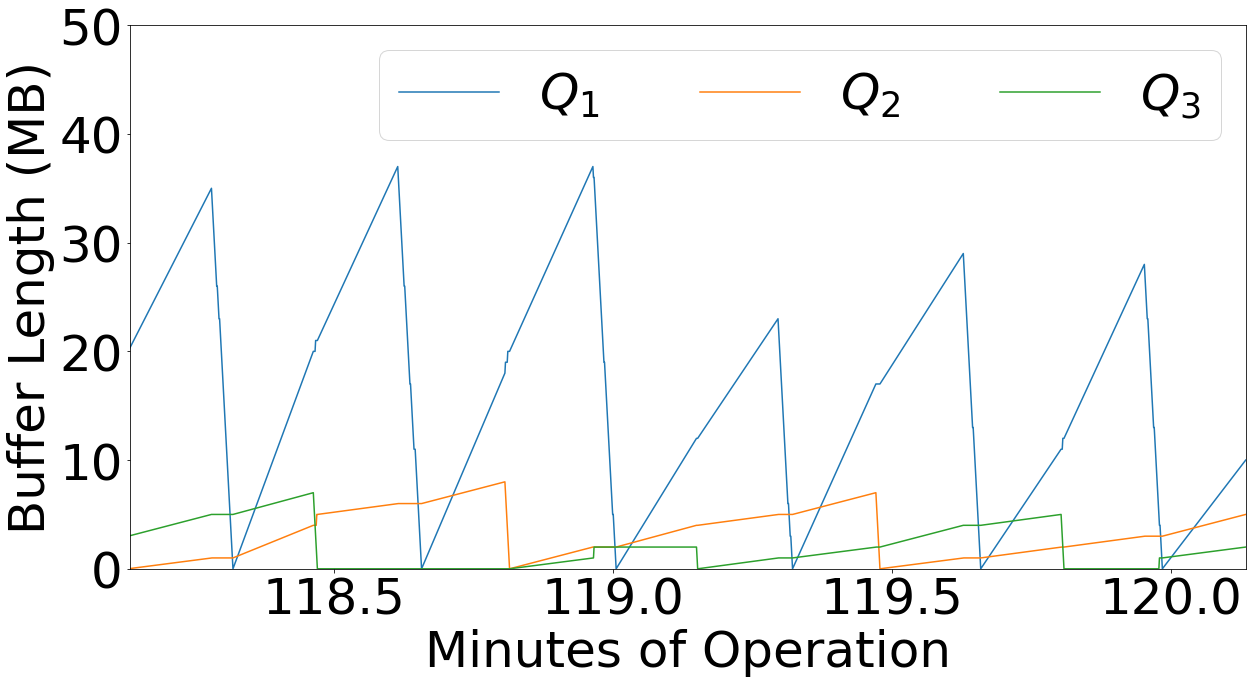

In [208]:
reload(sim)
sim.plotLastMins(xtv2, 2)
plt.ylim(0,50)
plt.savefig("", format="". bbox_inches="tight")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


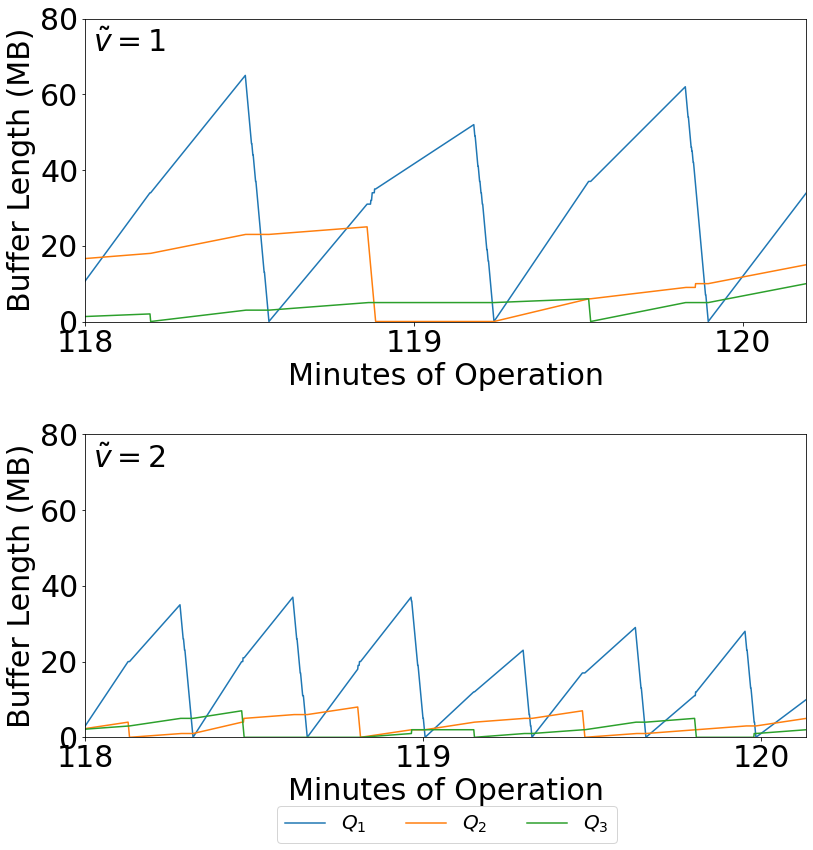

In [242]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 30})
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12))
mins = 2
xt = np.array(xt)
nd = xt.shape[1]
for i in range(2,nd):
    ax1.plot(xt[:,0]/60, xt[:,i], label = '$Q_%d$'%(i-1))

ax1.set_xlim((xt[-1,0]/60)-mins,xt[-1,0]/60)
ax1.set_ylim(0,80)
ax1.set_xlabel('Minutes of Operation')
ax1.set_xticks([118, 119, 120])
ax1.set_ylabel('Buffer Length (MB)')
ax1.annotate("$\\tilde{v} = 1$", xy=(0.01,0.89),xycoords='axes fraction',fontsize=30)

xtv2 = np.array(xtv2)
for i in range(2,nd):
    ax2.plot(xtv2[:,0]/60, xtv2[:,i], label = '$Q_%d$'%(i-1))

ax2.set_xlim((xtv2[-1,0]/60)-mins,xtv2[-1,0]/60)
ax2.set_ylim(0,80)

ax2.set_xlabel('Minutes of Operation')
ax2.set_xticks([118, 119, 120])
ax2.set_ylabel('Buffer Length (MB)')
ax2.annotate("$\\tilde{v} = 2$", xy=(0.01,0.89),xycoords='axes fraction',fontsize=30)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=20, loc='upper center', bbox_to_anchor=[0.546,0.05], ncol=n)
fig.tight_layout()
fig.savefig("eq_tri_sample_buffer_length_2vs.png", format="png", bbox_inches="tight")
fig.savefig("eq_tri_sample_buffer_length_2vs.eps", format="eps", bbox_inches="tight")

In [235]:
#now look at effect of speed
ps.Ls = np.array([0.1/beta, 0.01/beta, 0.01/beta])
speeds = [0.5, 1, 2, 5, 10]
ws = []
for speed in speeds:
    print("Finding AORP")
    AORP = sim.calc_AORP(dt_sys, speed)
    print("Found AORP")
    ws.append(AORP['WT'])


Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Finding AORP


/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP


In [236]:
def wmg1(ps):
    term1 = 1/ps.RhoSys()
    term2 = ( ps.beta*ps.RhoSys()**2 )/ ( 2*(1 - ps.RhoSys()) )
    return term1 * term2

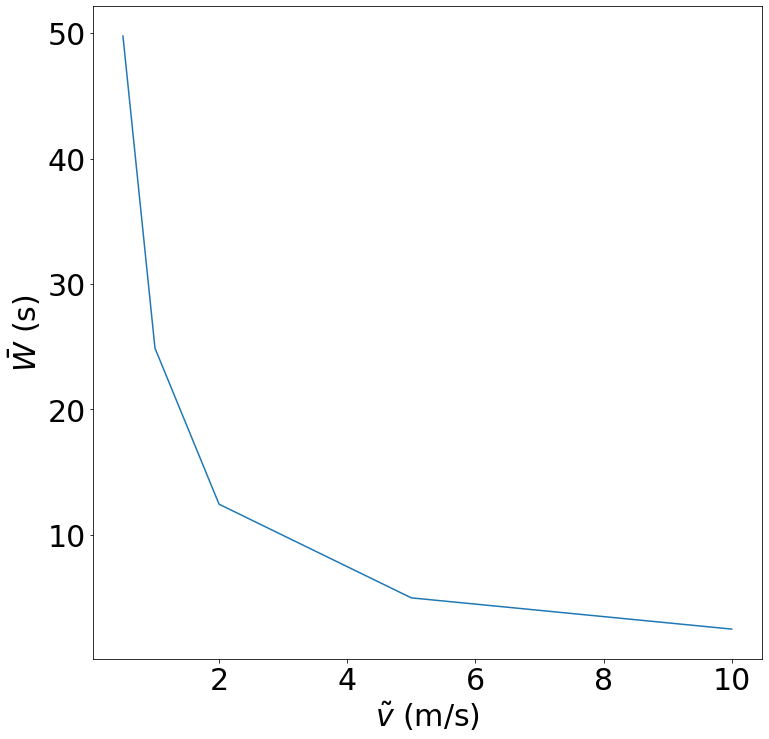

In [239]:
fig = plt.figure(figsize=(12,12))
plt.plot(speeds, ws)
plt.xlabel("$\\tilde{v}$ (m/s)")
plt.ylabel("$\\bar{W}$ (s)")
minw = wmg1(ps)
fig.savefig("eq_tri_w_v_v.png", format="png", bbox_inches="tight")
fig.savefig("eq_tri_w_v_v.eps", format="eps", bbox_inches="tight")

In [253]:
#now compare TSPNP, AORP, AORPT while varying offset
#now look for trends
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'font.size': 35})
v = 1
S_cy = dtr.XtoS(TSPNP['X'])
S_cyv = np.zeros(n)
seq = TSPNP['SEQ']
for i in range(n):
    S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]
    
    
W_aorp = []
W_tab = []
W_tspnp = []
s_tilde = []
dispersion = []

n_steps = 6
l = np.reshape(np.array([0, 20, 40, 60, 80, 100]),(n_steps,1))
offsets = -1*l*np.array([np.cos(np.pi/6), np.sin(np.pi/6)])
regions = np.reshape(np.array([x_max, x_min, y_max, y_min]), (4,1)) + np.array([np.zeros(n_steps), offsets[:,0], np.zeros(n_steps), offsets[:,1]])
regions = regions.T

d = len(scales)
vals = np.tile(np.array([0.01/beta, 0.01/beta, 0.01/beta]), (d,1))
vals[:,0]*=scales
els = np.array([0.2, 0.2, 0.2])/beta
ps.Ls =els

sys_traffic = 0.3
L_S = sys_traffic/beta

for offset, tregion in zip(offsets, regions):
    dt_sys.shiftRegion(0, offset)
    dt_sys.region = tregion
    tjcps[0] += offset
    pjcps[0] += offset
    qBase[0] += offset
    qBase[1] += offset
    
    #find the TSPNP
    sys_regions = dt_sys.cregions
    tspn_min, tspn_argmin = TSPN.TSPN_BF(sys_regions)
    TSPNP={'X':tspn_argmin[0], 'SEQ':tspn_argmin[1]}
    S_cy = dtr.XtoS(TSPNP['X'])
    S_cyv = np.zeros(n)
    seq = TSPNP['SEQ']
    for i in range(n):
        S_cyv[i] = S_cy[seq[i], seq[(i+1)%n]]
    
    print("Finding AORP")
    AORP = sim.calc_AORP(dt_sys, v)
    print("Found AORP")
    pi = AORP['pi']
    S = dtr.XtoS(AORP['X'])
    
    #also look at the tabular version
    rtable = SRP.SRPFromPis(pi, eps=0.01)
    seconds = 2*60*60
    xt, wt, queues, total_travel_time, _, _, _ = ps.simulate(rtable, S, seconds)
    W_tab.append(wt[-1][1])
    #S_i = S @ pi
    W_rnd = ps._calc_avg_wait_random(S, pi)
    W_aorp.append(W_rnd)
    W_cy = ps._calc_avg_wait_cyclic(S_cyv)
    W_tspnp.append(W_cy)

    P_tilde, pi_tilde = sim.pi_to_P(pi)
    S_obs = pi_tilde.T @ (S*P_tilde) @np.ones((3,1))
    s_tilde.append(S_obs)
    
    X = AORP['X']
    X_avg = np.average(X,0, weights=els)
    diffs = X - X_avg
    dists = np.linalg.norm(diffs, axis=1)
    #normalize - is this the best way to go?
    dists /= np.max(dists)
    dispersion.append(np.average(dists, weights=val))
    
    dt_sys.shiftRegion(0, -offset)#move back
    tjcps[0] -= offset
    pjcps[0] -= offset
    qBase[0] -= offset
    qBase[1] -= offset
    


Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
13 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 49.96
Elapsed Time: 0.27
Finding AORP
Found AORP
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
13 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
13 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 88.20
Elapsed Time: 0.25
Finding AORP
Found AORP
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
13 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
13 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved t

/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/win/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Found AORP
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
13 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
14 total subregions
Total of 1 Permutations to Try
Working on Permutation (0, 1, 2)
Optimal Solution Improved to 247.18
Elapsed Time: 0.20
Finding AORP
Found AORP
Extracted edges...
Polygons constructed, looking for holes...
Constructed 1 possibly non-convex polygons
13 total subregions


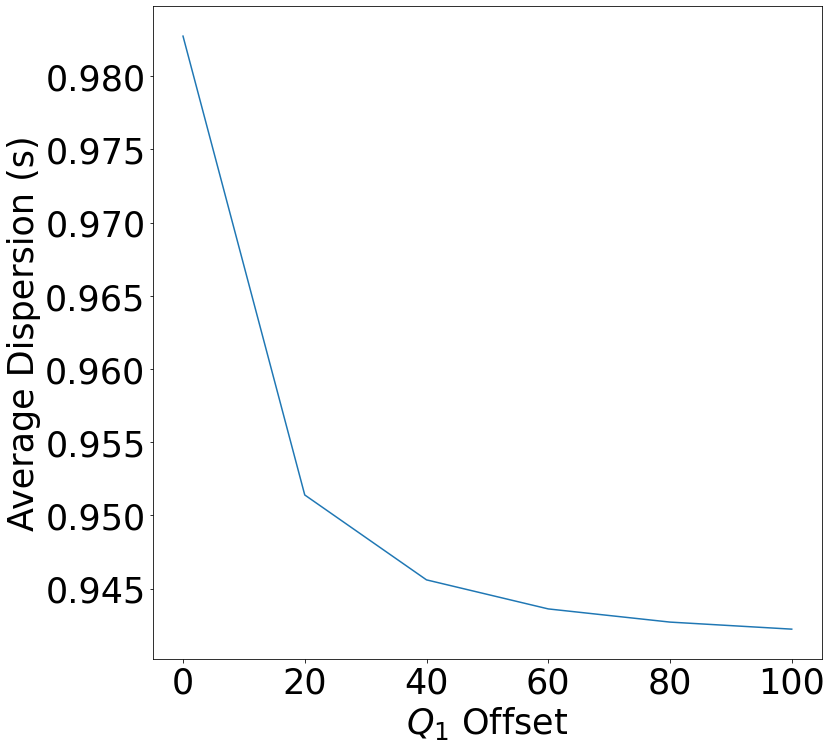

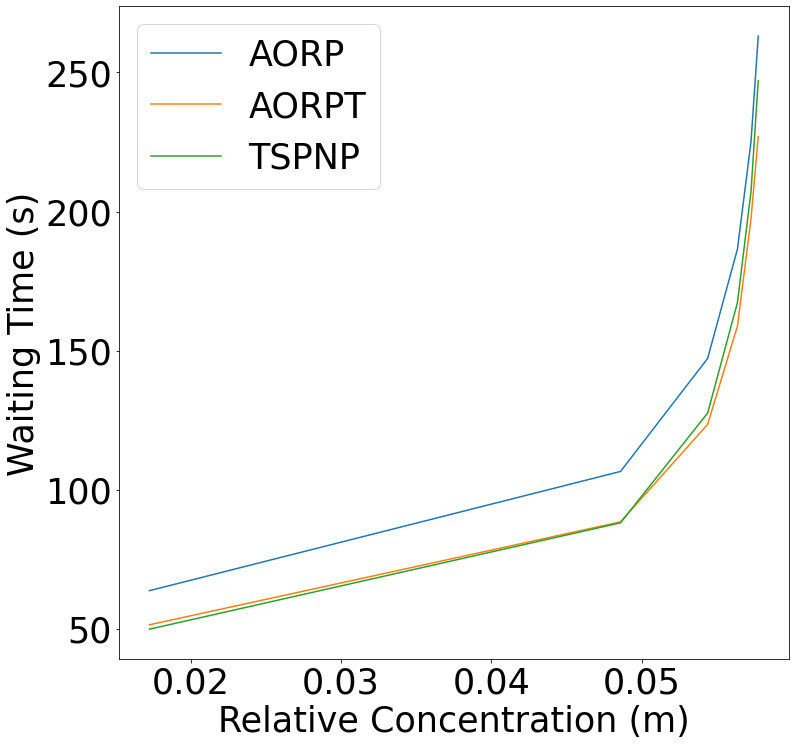

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


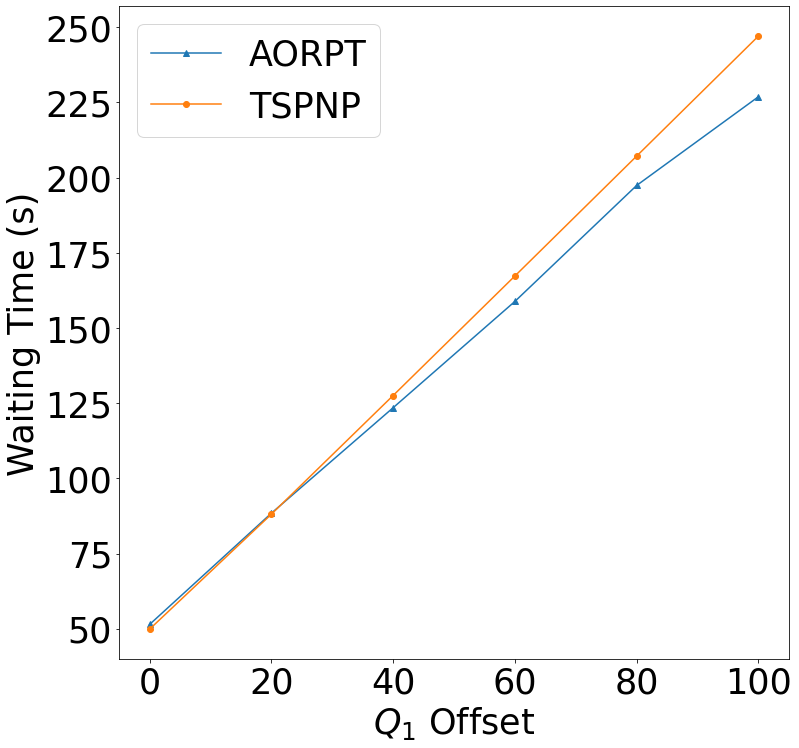

In [256]:
fig = plt.figure(figsize=(12,12))
plt.plot(l, dispersion)
plt.xlabel("$Q_1$ Offset")
plt.ylabel("Average Dispersion (s)")
plt.show()

dispersion = np.array(dispersion)
conc = 1-dispersion
order = np.argsort(conc).tolist()

fig = plt.figure(figsize=(12,12))
W_aorp = np.array(W_aorp)
plt.plot(conc[order], W_aorp[order], label="AORP")
W_tab = np.array(W_tab)
plt.plot(conc[order], W_tab[order],  label="AORPT")
W_tspnp = np.array(W_tspnp)
plt.plot(conc[order], W_tspnp[order], label="TSPNP")
plt.xlabel("Relative Concentration (m)")
plt.ylabel("Waiting Time (s)")
plt.legend()
plt.show()

fig = plt.figure(figsize=(12,12))
#plt.plot(l, W_aorp, '-s', label="AORP")
plt.plot(l, W_tab, '-^', label="AORPT")
plt.plot(l, W_tspnp, '-o', label="TSPNP")
plt.xlabel("$Q_1$ Offset")
plt.ylabel("Waiting Time (s)")
plt.legend()
plt.savefig("eq_tri_w_v_offset.png", format='png', bbox_inches='tight')
plt.savefig("eq_tri_w_v_offset.eps", format='eps', bbox_inches='tight')
plt.show()